# Clouds and cloud feedback

This notebook is part of [The Climate Laboratory](https://brian-rose.github.io/ClimateLaboratoryBook) by [Brian E. J. Rose](http://www.atmos.albany.edu/facstaff/brose/index.html), University at Albany.

____________
<a id='section1'></a>

## 1. Optical properties of individual clouds depend on the Cloud Liquid Water Path
____________


Let $w$ represent the liquid water content of a unit volume of cloudy air, in units of g m$^{-3}$.

Then the Liquid Water Path of the cloud is

$$LWP = w ~ \Delta z$$

where $\Delta z$ is the depth of the cloudy layer in meters.  $LWP$ has units of g m$^{-2}$.

$LWP$ determines the key optical properties of the cloud, both in the longwave and shortwave:

![Webster cloud optical properties schematic](../images/CloudOpticalProperties_Webster1994.png)

A key point about the optical properties of water clouds:

- longwave emissivity / absorptivity increases rapidly with $LWP$
- cloud albedo increases slowly with $LWP$

### Longwave effects of clouds

Because the emissivity saturates for moderately thin clouds, thick clouds behave very much like blackbody absorbers at every level. Emissions from below and within the cloud will be absorbed by the upper part of the cloud.

Emissions to space are therefore **governed by the top of the cloud**.

The longwave effects of a thick cloud thus depend strongly on the **temperature at the top of the cloud**. This temperature is determined primarily by the **height of the cloud top**.

A high-top cloud will exert a strong greenhouse effect because it absorbs upwelling longwave radiation and re-emits radiation at its cold temperature.

The longwave effects of clouds tend to warm the surface.

### Shortwave effects of clouds

Because clouds increase the planetary albedo, the shortwave effects of clouds tend to cool the surface.

The same cloud therefore pushes the planetary energy budget in two directions simultaneously. Which effect dominates depends on

- the temperature at the cloud top relative to the surface temperature
- the cloud liquid water path (cloud depth)

Thin clouds are relatively transparent to solar radiation. Thick clouds are effective reflectors.

A thin cirrus cloud, for example, has a negligible albedo but exerts a substantial greenhouse effect because it is near the cold tropopause. These clouds have a net warming effect.

A relatively thick stratus cloud at the top of the planetary boundary layer reflects significant incoming solar radiation. But the temperature at cloud top is not much different from the surface temperature, so the greenhouse effect is negligible (even though the cloud is a very strong longwave absorber!)

____________
<a id='section2'></a>

## 2. Cloudy sky versus clear sky radiation
____________

Let $F = ASR - OLR$ be the net incoming radiation at TOA.

Suppose that the average flux in the portion of the sky **without clouds** is $F_{clear}$.

We'll call the flux in the cloudy portion of the sky $F_{cloudy}$.

Then the total flux is a weighted sum

$$ F = (1-c) F_{clear} + c F_{cloudy} $$

where $0 \le c \le 1$ is the **cloud fraction**, i.e. the fraction of the sky covered by cloud.

We can of course break this up into long- and shortwave components:

$$ F = F_{LW} + F_{SW} $$

$$ F_{LW} = - \big((1-c)~OLR_{clear} + c ~ OLR_{cloudy} \big)$$

$$ F_{SW} = + \big((1-c)~ASR_{clear} + c ~ ASR_{cloudy} \big)$$

The clouds will act to warm this surface if $F_{cloudy} > F_{clear}$, in which case the net flux $F$ will increase with the cloud fraction $c$.

In our examples above we surmised the following:

#### High thin cirrus
- $ASR_{cloudy} \approx ASR_{clear} $
- $OLR_{cloudy} < OLR_{clear}$
- $F$ increases with $c$ (these clouds warm the surface)

#### Low stratus
- $ASR_{cloudy} < ASR_{clear} $
- $OLR_{cloudy} \approx OLR_{clear}$
- $F$ decreases with $c$ (these clouds cool the surface)

Many other cloud types are ambiguous. For example: 

#### Deep convective cumulonimbus

- $ASR_{cloudy} < ASR_{clear} $
- $OLR_{cloudy} < OLR_{clear}$
- $F$ might either increase or decrease with $c$

We need a model to work out the details!

____________
<a id='section3'></a>

## 3. Cloud Radiative Effect (CRE)
____________

Typically there is not just one cloud type but many to deal with simultaneously, whether in nature (satellite observations) or in a GCM.

In practice we rarely calculate $F_{cloudy}$ explicitly.

Instead we define the **Cloud Radiative Effect** as

$$ CRE =  F - F_{clear} $$

which we can write in terms of cloud fraction:

$$ CRE = c \big( F_{cloudy} - F_{clear} \big) $$

In our above examples, $CRE$ is positive for cirrus, negative for low stratus, and unknown for cumulonimbus.

We calculated CRE (including both longwave and shortwave components) in the CESM simulations back in Assignment 4.

____________
<a id='section4'></a>

## 4. Modeling the dependence of CRE on cloud height
____________

We are now going to use the `RRTMG` radiation model to compute the cloud radiative effect in a single column, and look at how the CRE depends on cloud properties and the height of the cloud layer.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import climlab
from climlab.radiation import RRTMG

### Global average observed temperature and specific humidity

In [2]:
#  Get temperature and humidity data from NCEP Reanalysis
import xarray as xr
ncep_url = "http://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/ncep.reanalysis.derived/pressure/"
path = ncep_url
ncep_air = xr.open_dataset(path + 'air.mon.1981-2010.ltm.nc', decode_times=False)
ncep_shum = xr.open_dataset(path + 'shum.mon.1981-2010.ltm.nc', decode_times=False)
## The NOAA ESRL server is shutdown! January 2019
#url = 'http://apdrc.soest.hawaii.edu:80/dods/public_data/Reanalysis_Data/NCEP/NCEP/clima/pressure/'
#air = xr.open_dataset(url + 'air')
#shum = xr.open_dataset(url + 'shum')
#ncep_air = air.rename({'lev': 'level'})
#ncep_shum = shum.rename({'lev': 'level'})

In [3]:
#  Take global, annual average and convert to correct units (Kelvin and kg/kg)
weight = np.cos(np.deg2rad(ncep_air.lat)) / np.cos(np.deg2rad(ncep_air.lat)).mean(dim='lat')
Tglobal = (ncep_air.air * weight).mean(dim=('lat','lon','time')) + climlab.constants.tempCtoK
SHglobal = (ncep_shum.shum * weight).mean(dim=('lat','lon','time')) * 1E-3  # kg/kg

Since we will be creating a radiative model with a different set of pressure levels than the data, we will need to do some interpolating.

In [4]:
#  Create a state dictionary with 50 levels
state = climlab.column_state(num_lev=50)
lev = state.Tatm.domain.axes['lev'].points

In [5]:
# interpolate to model pressure levels
Tinterp = np.interp(lev, np.flipud(Tglobal.level), np.flipud(Tglobal))
SHinterp = np.interp(lev, np.flipud(SHglobal.level), np.flipud(SHglobal))
#  Need to 'flipud' because the interpolation routine 
#  needs the pressure data to be in increasing order

Text(0.5, 1.03, 'Global mean air temperature and specific humidity')

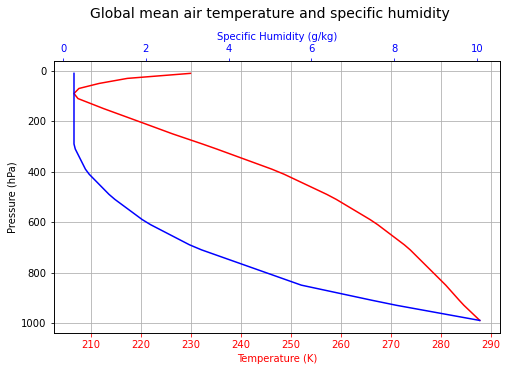

In [6]:
#  Plot the temperature and humidity profiles
fig, ax1 = plt.subplots(figsize=(8,5))
Tcolor = 'r'
SHcolor = 'b'
ax1.plot(Tinterp, lev, color=Tcolor)
ax1.invert_yaxis()
ax1.set_xlabel('Temperature (K)', color=Tcolor)
ax1.tick_params('x', colors=Tcolor)
ax1.grid()
ax1.set_ylabel('Pressure (hPa)')
ax2 = ax1.twiny()
ax2.plot(SHinterp*1E3, lev, color=SHcolor)
ax2.set_xlabel('Specific Humidity (g/kg)', color=SHcolor)
ax2.tick_params('x', colors=SHcolor)
fig.suptitle('Global mean air temperature and specific humidity', y=1.03, fontsize=14)

In [7]:
#  Set the temperature to the observed values
state.Tatm[:] = Tinterp

In [8]:
#  Define some local cloud characteristics
#  We are going to repeat the calculation 
#   for three different types of clouds:
#   thin, medium, and thick
cldfrac = 0.5  # layer cloud fraction
r_liq = 14.  # Cloud water drop effective radius (microns)
# in-cloud liquid water path (g/m2)
clwp = {'thin': 20.,
        'med': 60.,
        'thick': 200.,}

In [9]:
#  Loop through three types of cloud
#  for each type, loop through all pressure levels
#  Set up a radiation model with the cloud layer at the current pressure level
#  Compute CRE and store the results
CRE_LW = {}
CRE_SW = {}
for thickness in clwp:
    OLR = np.zeros_like(lev)
    ASR = np.zeros_like(lev)
    OLRclr = np.zeros_like(lev)
    ASRclr = np.zeros_like(lev)
    for i in range(lev.size):
        # Whole-column cloud characteristics
        #  The cloud fraction is a Gaussian bump centered at the current level        
        mycloud = {'cldfrac': cldfrac*np.exp(-(lev-lev[i])**2/(2*25.)**2),
                   'clwp': np.zeros_like(state.Tatm) + clwp[thickness],
                   'r_liq': np.zeros_like(state.Tatm) + r_liq,}
        rad = RRTMG(state=state, 
                    albedo=0.2,
                    specific_humidity=SHinterp,
                    verbose=False,
                    **mycloud)
        rad.compute_diagnostics()
        OLR[i] = rad.OLR
        OLRclr[i] = rad.OLRclr
        ASR[i] = rad.ASR
        ASRclr[i] = rad.ASRclr
    CRE_LW[thickness] = -(OLR - OLRclr)
    CRE_SW[thickness] = (ASR - ASRclr)

Text(0.5, 0.98, 'Cloud Radiative Effect as a function of the vertical height of the cloud layer')

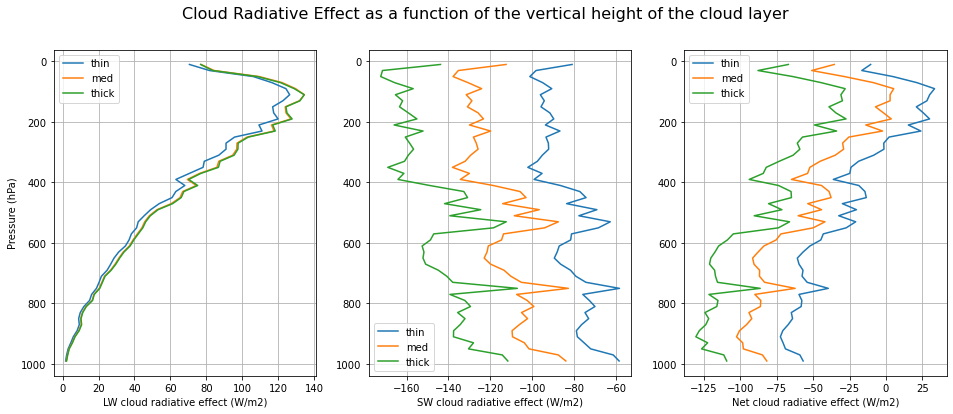

In [10]:
#  Make some plots of the CRE dependence on cloud height
fig, axes = plt.subplots(1,3, figsize=(16,6))
ax = axes[0]
for thickness in clwp:
    ax.plot(CRE_LW[thickness], lev, label=thickness)
ax.set_ylabel('Pressure (hPa)')
ax.set_xlabel('LW cloud radiative effect (W/m2)')

ax = axes[1]
for thickness in clwp:
    ax.plot(CRE_SW[thickness], lev, label=thickness)
ax.set_xlabel('SW cloud radiative effect (W/m2)')

ax = axes[2]
for thickness in clwp:
    ax.plot(CRE_SW[thickness] + CRE_LW[thickness], lev, label=thickness)
ax.set_xlabel('Net cloud radiative effect (W/m2)')

for ax in axes:
    ax.invert_yaxis()
    ax.legend()
    ax.grid()
fig.suptitle('Cloud Radiative Effect as a function of the vertical height of the cloud layer', fontsize=16)

What do you see here? Look carefully at how the LW and SW effects of the cloud depend on cloud properties and cloud height.

____________
<a id='section5'></a>

## 5. Cloud Feedback
____________

$CRE$ (the radiative effects of clouds) depends on two cloud properties:

- cloud fraction $c$
- cloud LWP, which determines $F_{cloudy}$

If either or both of these things change as the climate changes and the surface warms, then there is an additional TOA energy source that will help determine the final equilibrium warming --  a feedback!

The cloud feedback thus depends on changes in the frequency of occurrence and the optical properties of all the different cloud types. It's an enormously complex problem.

Following the notation in [the lecture on climate sensitivity and feedback](https://brian-rose.github.io/ClimateLaboratoryBook/courseware/sensitivity-feedback.html), we can write the change in the top-of-atmosphere energy budget after the response to a radiative forcing $\Delta R$ as

$$ \Delta F = \Delta R - \Delta T \left( \lambda_0 - \sum_{i=1}^N \lambda_i \right)  $$

where $\lambda_0$ is the "Planck feedback", or, more precisely, the no-feedback response parameter, while the $\lambda_i$ are all the additive feedback parameters.

Now using 

$$ F = (1-c) F_{clear} + c F_{cloudy} $$

we can break up the change in $F$ into components due to changes in cloud fraction, clear-sky flux, and cloud optical properties:

$$ \Delta F = (1-c)\Delta F_{clear}  + c \Delta F_{cloudy}  +\left( F_{cloudy} - F_{clear} \right) \Delta c $$

where $c, F_{cloudy}, F_{clear}$ here would be evaluated from the reference (control) climate, and we assume the changes are small so that the linearization is sensible.

### Clear-sky and cloud feedbacks

Equating our two expressions for the TOA change $\Delta F$ gives

$$ (1-c)\Delta F_{clear}  + c \Delta F_{cloudy}  +\left( F_{cloudy} - F_{clear} \right) \Delta c = \Delta R - \Delta T \left( \lambda_0 - \sum_{i=1}^N \lambda_i \right) $$


We can break down the net feedback in many different ways, but here we will just conceptually separate clear-sky and cloud feedbacks:

$$ \sum_{i=1}^N \lambda_i = \lambda_{clear} + \lambda_{cloud} $$

A sensible definition of $\lambda_{cloud}$ would be involve **only changes in cloud fraction and properties**. We thus formally define

$$ \lambda_{cloud} = c \frac{\Delta F_{cloudy}}{\Delta T}  +\left( F_{cloudy} - F_{clear} \right) \frac{\Delta c}{\Delta T} $$

which we subtract from the net top-of-atmosphere budget to get

$$ (1-c)\Delta F_{clear}  = \Delta R - \Delta T \left( \lambda_0 - \lambda_{clear} \right) $$



which suggests that we can estimate the **clear-sky feedback** from

$$ \lambda_{clear} = \lambda_0 - \frac{\Delta R}{\Delta T} + (1-c) \frac{\Delta F_{clear}}{\Delta T}$$

This includes processes such as lapse rate feedback, water vapor feedback, and surface albedo feedback.

Remember that all of these expressions can be (and frequently are) decomposed into longwave and shortwave components.

### Cloud feedback vs. CRE

GCM diagnostics usually provide $CRE$ (which are computed by making second passes through the radiation code with the cloud fractions set to zero).

As we did in Assignment 4, we can compute the **change in $CRE$** between a control and perturbation climate.

One key point here is that **the change in $CRE$ is not equivalent to a cloud feedback**.

To see this, first note that 

$$ \Delta CRE = \Delta F - \Delta F_{clear} $$

Using the above definitions we can write this as

$$ \Delta CRE = -c \Delta F_{clear}  + \Delta T \lambda_{cloud} $$

The **clear sky feedback** affects the change in $CRE$ we can measure in a GCM, or observations.

Suppose there is **no change in cloud fraction or cloud optical properties**. By definition then $\lambda_{cloud} = 0$. But we would still measure a non-zero change in $CRE$.

Why?

Because the flux in the clear-sky fraction is changing!

#### So how do we compute $\lambda_{cloud}$?

So long as $\lambda_{clear}$ is known, it's easy:

Just measure  $\frac{\Delta CRE}{\Delta T}$ and the cloud fraction $c$ from the model, and solve the above formula to get

$$ \lambda_{cloud}  = \frac{\Delta CRE}{\Delta T} + \frac{\Delta F_{clear}}{\Delta T} + \lambda_{0} - \lambda_{clear} - \frac{\Delta R}{\Delta T}$$

This is how we can "correct" the change in $CRE$ to get the actual cloud feedback.

____________
<a id='section6'></a>

## 6. Feedback measured in comprehensive GCMs
____________


<img src='http://www.climatechange2013.org/images/figures/WGI_AR5_Fig9-43.jpg'>

> **Figure 9.43** | (a) Strengths of individual feedbacks for CMIP3 and CMIP5 models (left and right columns of symbols) for Planck (P), water vapour (WV), clouds (C), albedo (A), lapse rate (LR), combination of water vapour and lapse rate (WV+LR) and sum of all feedbacks except Planck (ALL), from Soden and Held (2006) and Vial et al. (2013), following Soden et al. (2008). CMIP5 feedbacks are derived from CMIP5 simulations for abrupt fourfold increases in CO2 concentrations (4 × CO2). (b) ECS obtained using regression techniques by Andrews et al. (2012) against ECS estimated from the ratio of CO2 ERF to the sum of all feedbacks. The CO2 ERF is one-half the 4 × CO2 forcings from Andrews et al. (2012), and the total feedback (ALL + Planck) is from Vial et al. (2013).

*Figure caption reproduced from the AR5 WG1 report*

____________
<a id='section7'></a>

## 7. Measuring $\lambda_{clear}$ with radiative kernels
____________



So how are the clear-sky feedbacks (P, WV, LR, A) actually calculated?

Presently, the most popular technique the method of **radiative kernels**.

You have been building a (primitive) kernel for the water vapor feedback in the last homework.

![Held and Soden kernels](../images/Kernels_Held&Soden2000.png)

> Held, I. M. and Soden, B. J. (2000). Water vapor feedback and global warming. Ann. Rev. Energy Environ., 25:441–475.

**These notes are unfinished.**

____________

## Credits

This notebook is part of [The Climate Laboratory](https://brian-rose.github.io/ClimateLaboratoryBook), an open-source textbook developed and maintained by [Brian E. J. Rose](http://www.atmos.albany.edu/facstaff/brose/index.html), University at Albany.

It is licensed for free and open consumption under the
[Creative Commons Attribution 4.0 International (CC BY 4.0)](https://creativecommons.org/licenses/by/4.0/) license.

Development of these notes and the [climlab software](https://github.com/brian-rose/climlab) is partially supported by the National Science Foundation under award AGS-1455071 to Brian Rose. Any opinions, findings, conclusions or recommendations expressed here are mine and do not necessarily reflect the views of the National Science Foundation.
____________